In [3]:
import numpy as np
import os
from PIL import Image
from IPython.display import SVG
from sklearn.model_selection import train_test_split

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# Display full output in Jupyter, not only last result.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
# DL imports
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,Adam
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import load_img, img_to_array

2023-04-22 17:37:14.128009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 17:37:14.200401: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/neo/swarm_project_ws/devel/lib:/opt/ros/noetic/lib
2023-04-22 17:37:14.200416: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-22 17:37:14.647787: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnv

In [6]:
def image_to_array(folder_path, result, image_max):
    '''
    input: folder path
    output: X and y matrices
    X - image matrix;
    y - labels/result: 0 as clear and 1 as blur
    image_max - max number of images to include
    '''
    X = []; y = []

    for index, file_name in enumerate(os.listdir(folder_path)[:image_max]):
         if file_name != '.DS_Store':
            image_path = folder_path + '/' + file_name
            img = load_img(image_path, target_size=(200, 200))
            # img = img.convert('1')
            X.append(np.asarray(img))
            y.append(result) # 0 for clear; 1 for blurry

            if index < 3:
                # check the file names
                print('Adjusted image size -', img.size, '| filename -', file_name)
            else:
                if index % 100 == 0:
                    # check the progress when loading large dataset
                    print(index, 'images loaded so far')

    print('---\n', len(X), 'images in this folder\n')

    return X, y

In [7]:
def check_image_from_folder(folder_path, image_index):
    '''
    input: folder path & index of the image within the folder
    output: show the image
    '''
    file_name = str(os.listdir(folder_path)[image_index])
    image_path = folder_path + '/' + file_name
    img = load_img(image_path, target_size=(200, 200))
    return img

In [8]:
def predict_folder_image(model, folder_path, image_index):
    '''
    input: folder path, index of the image inside the folder
    output: show the image and the result predicted from the model
    '''
    
    print('Folder: ',folder_path.split('/')[-1])
    
    test_pic= []
    
    file_name = os.listdir(folder_path)[image_index]
    
    if file_name != '.DS_Store':
        image_path = folder_path + '/' + file_name
        img = load_img(image_path, target_size=(200, 200))
        test_pic.append(np.asarray(img))
        test_pic = np.stack(test_pic)/255.

        result = model.predict_classes(test_pic)#[0]
        proba = model.predict_proba(test_pic)
        print(result, proba)
        
    else:
        img = 'This is DS_Store file'
    
    return img

In [9]:
# Test the loading of Data into jupyter
np.set_printoptions(threshold=np.inf)

# Path for the Blurred images folder
folder_path = '/home/neo/ML-DL/blurry_detection/data/TrainingSet/TrainingSet/Blurred'

image_dimension = (200, 200)

X_cat = []
y_cat =[]
# Test to see if the files are boing loaded correctly
for index, file_name in enumerate(os.listdir(folder_path)[:5]):
     if file_name != '.DS_Store':
        image_path = folder_path + '/' + file_name
        print(image_path)
        img = load_img(image_path, target_size=image_dimension)
        # img
        X_cat.append(np.asarray(img))
        y_cat.append(0) # 0 for clear; 1 for blurry

type(X_cat)
X_cat = np.array(X_cat)
type(X_cat)
X_cat.shape
type(X_cat[0])
X_cat[0].shape

/home/neo/ML-DL/blurry_detection/data/TrainingSet/TrainingSet/Blurred/DiskR10_DSC02251.JPG
/home/neo/ML-DL/blurry_detection/data/TrainingSet/TrainingSet/Blurred/DiskR10_100_1830.jpg
/home/neo/ML-DL/blurry_detection/data/TrainingSet/TrainingSet/Blurred/DiskR3_IMG_7769.JPG
/home/neo/ML-DL/blurry_detection/data/TrainingSet/TrainingSet/Blurred/GaussianH1x50S250_28.jpg
/home/neo/ML-DL/blurry_detection/data/TrainingSet/TrainingSet/Blurred/MotionL50H90_11.jpg


list

numpy.ndarray

(5, 200, 200, 3)

numpy.ndarray

(200, 200, 3)

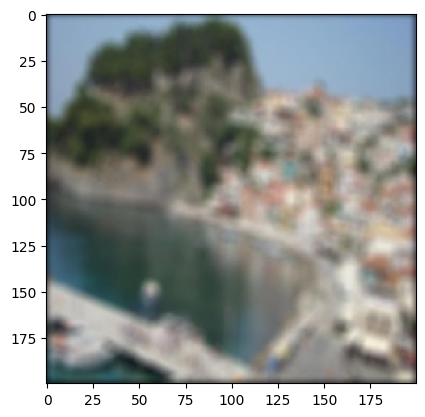

In [10]:
# Select an image and display it
plt.imshow(X_cat[0], cmap=plt.get_cmap('gray'))
plt.show()

In [11]:
# Set the paths to the 2 classes : Blurred and Clear images
folder_path_clear = '/home/neo/ML-DL/blurry_detection/data/TrainingSet/TrainingSet/Undistorted'
folder_path_blurry = '/home/neo/ML-DL/blurry_detection/data/TrainingSet/TrainingSet/Blurred'

print('How many images in total?')
print('Clear images: ', len(os.listdir(folder_path_clear)))
print('Blurry images: ', len(os.listdir(folder_path_blurry)))

How many images in total?
Clear images:  630
Blurry images:  150


In [12]:
# Loading the clear images as numpy arrays 
print('\nLoading clear images\n---')
X_clear, y_clear = image_to_array(folder_path_clear, 0, 1000)

# Loading the blurry images as numpy arrays 
print('Loading blurry images\n---')
X_blurry, y_blurry = image_to_array(folder_path_blurry, 1, 1000)

# Combine the array's together
X = np.concatenate((X_clear,X_blurry), axis=0)
y = np.concatenate((y_clear,y_blurry), axis=0)

print('\nData collection is done!')



Loading clear images
---
Adjusted image size - (200, 200) | filename - DSCN1283.JPG
Adjusted image size - (200, 200) | filename - DSC00046.JPG
Adjusted image size - (200, 200) | filename - CIMG0376.JPG
100 images loaded so far
200 images loaded so far
300 images loaded so far
400 images loaded so far
500 images loaded so far
600 images loaded so far
---
 630 images in this folder

Loading blurry images
---
Adjusted image size - (200, 200) | filename - DiskR10_DSC02251.JPG
Adjusted image size - (200, 200) | filename - DiskR10_100_1830.jpg
Adjusted image size - (200, 200) | filename - DiskR3_IMG_7769.JPG
100 images loaded so far
---
 150 images in this folder


Data collection is done!


Example clear image


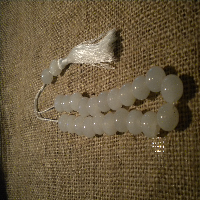

Example blurry image


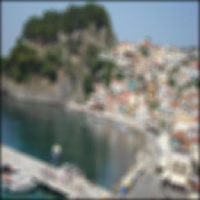

In [13]:
# Choosing an example to load
image_index = 0
# Loading an example of a clear image
print('Example clear image')
file_name = str(os.listdir(folder_path_clear)[image_index])
image_path = folder_path_clear + '/' + file_name
img = load_img(image_path, target_size=(200, 200))
img

# Loading an example of a blur image
print('Example blurry image')
file_name = str(os.listdir(folder_path_blurry)[image_index])
image_path = folder_path_blurry + '/' + file_name
img = load_img(image_path, target_size=(200, 200))
img

The picture is blurry


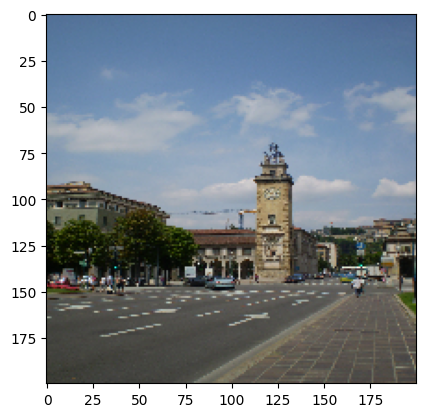

In [14]:
# Performing a sanity check on the data loaded in X and Y arrays
image_id = 11
X_check = X[image_id].astype('float32')
y_check = y[image_id] # [1,0] - clear; [0,1] - blurry

if y_check == int(to_categorical(y_blurry)[0,0]):
    print('The picture is blurry')
elif y_check == int(to_categorical(y_clear)[0,0]):
    print('The picture is clear')
else:
    print('Somthing is wrong. The data is loaded incorrectly')
    pass

plt.imshow(X[image_id], cmap=plt.get_cmap('gray'))
plt.show()

In [59]:
# The next step is to Pre-Processing of the data

In [60]:
# NORMALIZATION of the data to fit into (0,255)
X = np.stack(X)
X = X.astype('float32')
X = X/255

y = to_categorical(y)

np.array(X).shape
np.array(y).shape

(780, 200, 200, 3)

(780, 2)

In [61]:
# Statistical Check of parameters to ensure that there isnt too many outliers
stats = [np.min, np.max, np.mean, np.std]
stats_str = ['min -', 'max -', 'mean- ', 'std -']
print('X')
for index, stat in enumerate(stats):
    print(stats_str[index], stat(X))
print('y')
for index, stat in enumerate(stats):
    print(stats_str[index], stat(y))

X
min - 0.0
max - 1.0
mean-  0.44719127
std - 0.27161732
y
min - 0.0
max - 1.0
mean-  0.5
std - 0.5


In [62]:
# Saving the train and test data as numpy arrays for backup
np.save('/home/neo/ML-DL/blurry_detection/data/TrainingSet/X_norm_labels_clear_blurry.npy', X)
np.save('/home/neo/ML-DL/blurry_detection/data/TrainingSet/Y_norm_labels_clear_blurry.npy', y)

In [63]:
# MODEL DEFINITION AND TRAINING

In [64]:
# define the data and key parameters in the model
# Number of output labels 1 - p(Image is blurred) 2 - p(Image is not blurred)
labels = 2
# Loading the data from arrays
X = np.load('/home/neo/ML-DL/blurry_detection/data/TrainingSet/X_norm_labels_clear_blurry.npy')
y = np.load('/home/neo/ML-DL/blurry_detection/data/TrainingSet/Y_norm_labels_clear_blurry.npy')

X.shape
y.shape

(780, 200, 200, 3)

(780, 2)

In [66]:
# Split the data into X_train and Y_train data(80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=int(0.8*len(X)), random_state=42)

In [67]:
# Dimensions of the training data
print('Dimensions of Training Data\n---')
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

Dimensions of Training Data
---
X_train (624, 200, 200, 3)
X_test (156, 200, 200, 3)
y_train (624, 2)
y_test (156, 2)


In [68]:
# Model Definition
input_dimension = (200, 200, 3)

model = Sequential()

# Layer 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_dimension))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # to avoid overfitting

# Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
# Layer 4
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

# Layer 5
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))

# Layer 6
model.add(Dense(labels, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

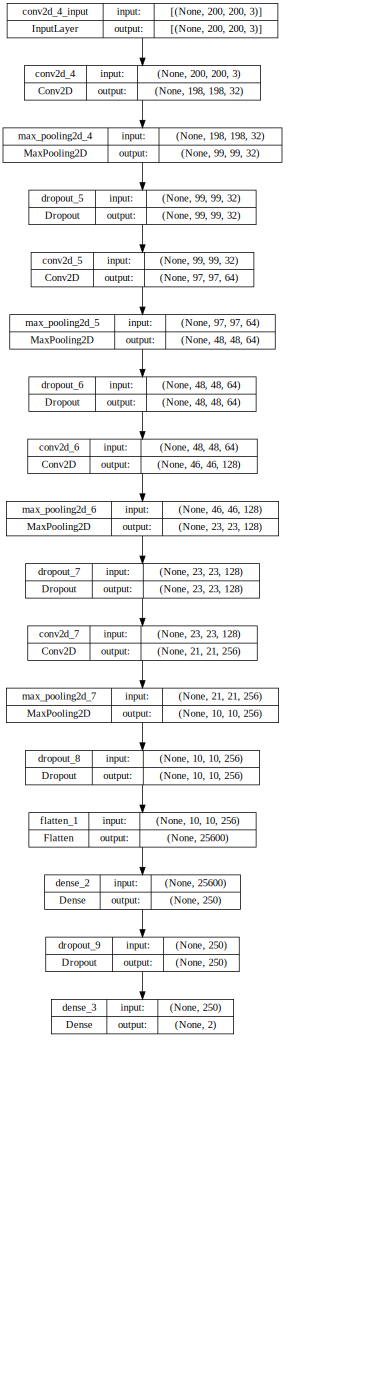

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 99, 99, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 48, 48, 64)       

In [69]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
model.summary()

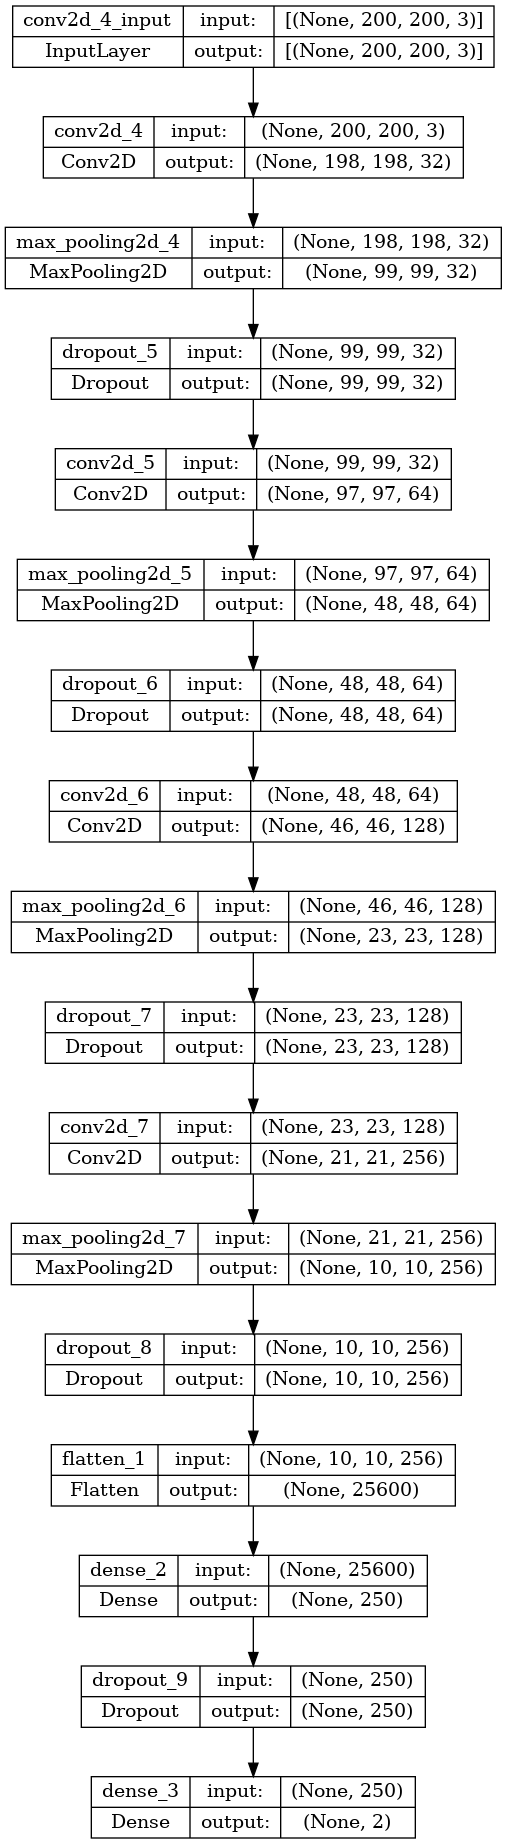

In [70]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [71]:
# Define the metrics for storing the loss and accuracy
import tensorflow as tf
metrics = {"loss": [],"accuracy": [],"val_loss": [],"val_accuracy": []}
class ModelMonitor(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        metrics["loss"].append(logs["loss"])
        metrics["accuracy"].append(logs["accuracy"])
        #metrics["val_loss"].append(logs["val_loss"])
        #metrics["val_accuracy"].append(logs["val_accuracy"])

In [72]:
# TRAINING

In [77]:
# Train the model to fit X_train and Y_train.
model.fit(X_train, y_train,
          batch_size=20,
          epochs=10, #10
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=ModelMonitor())

Epoch 1/10
32/32 [==============================] - 10s 311ms/step - loss: 0.2656 - accuracy: 0.8830 - val_loss: 0.3108 - val_accuracy: 0.8782
Epoch 2/10
32/32 [==============================] - 10s 301ms/step - loss: 0.2062 - accuracy: 0.9327 - val_loss: 0.2007 - val_accuracy: 0.9167
Epoch 3/10
32/32 [==============================] - 10s 303ms/step - loss: 0.1726 - accuracy: 0.9279 - val_loss: 0.1797 - val_accuracy: 0.9487
Epoch 4/10
32/32 [==============================] - 10s 303ms/step - loss: 0.1514 - accuracy: 0.9439 - val_loss: 0.1622 - val_accuracy: 0.9295
Epoch 5/10
32/32 [==============================] - 10s 304ms/step - loss: 0.1561 - accuracy: 0.9407 - val_loss: 0.2028 - val_accuracy: 0.9103
Epoch 6/10
32/32 [==============================] - 10s 306ms/step - loss: 0.1269 - accuracy: 0.9535 - val_loss: 0.1442 - val_accuracy: 0.9423
Epoch 7/10
32/32 [==============================] - 10s 307ms/step - loss: 0.1382 - accuracy: 0.9391 - val_loss: 0.1340 - val_accuracy: 0.9487

In [78]:
# Save the model as a .h5 file
model.save('/home/neo/ML-DL/blurry_detection/train_1_10.h5')

In [79]:
# Validate the model on the test data
scores = model.evaluate(X_test, y_test, verbose=1)

5/5 [==============================] - 0s 90ms/step - loss: 0.1266 - accuracy: 0.9359


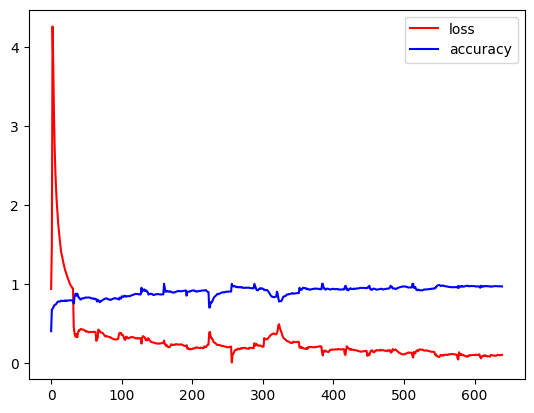

In [80]:
# Plot the metrics
plt.plot(metrics["loss"],color='red', label='loss')
plt.plot(metrics["accuracy"],color='blue', label='accuracy')
plt.legend()
plt.show()

In [81]:
# Save the metrics plot
plt.savefig('/home/neo/ML-DL/blurry_detection/model_params_1_10.png')

<Figure size 640x480 with 0 Axes>

In [85]:
# Test for the model
import numpy as np
import tensorflow as tf
import cv2
import h5py
# Load the model from the .h5 file
model_file = '/home/neo/ML-DL/blurry_detection/train_1.h5'
model_test = tf.keras.models.load_model(model_file)

# Load the image you want to predict on
image_file = '/home/neo/ML-DL/blurry_detection/data/TrainingSet/gaussian_blur_test.jpg'
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (200, 200))
image = np.expand_dims(image, axis=0)

# Make the prediction
prediction = model_test.predict(image)
print(f"model predicted {prediction[0][0]}")

1/1 [==============================] - 0s 52ms/step
model predicted 1.0
